# Encoding interactions

Interactions are always pairwise and always between encoders (and not features). 

The supported interactions are between: (a) categorical and categorical encoders, (b) categorical and linear encoders, (c) categorical and spline encoders, (d) linear and linear encoders, and (e) spline and spline encoders.

All encoders have a `n_features_out_` property after fitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_friedman1
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from feature_encoders.utils import tensor_product, add_constant
from feature_encoders.generate import CyclicalFeatures, DatetimeFeatures
from feature_encoders.encode import (
    CategoricalEncoder,
    ICatEncoder,
    SplineEncoder,
    ISplineEncoder,
    IdentityEncoder,
    ProductEncoder,
    ICatLinearEncoder,
    ICatSplineEncoder
)

## Load demo data

In [3]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]

## Pairwise interactions between categorical features

`ICatEncoder` encodes the interaction between two categorical features. Both encoders should have the same `encode_as` parameter.

If `encode_as = 'onehot'`, it returns the tensor product of the results of the two encoders. The tensor product combines row-per-row the results from the first and the second encoder as follows:

![tensor product](images/tensor.png)

A small example of the tensor product function:

In [4]:
a = np.array([1, 10]).reshape(1, -1)
b = np.array([10, 20, 30]).reshape(1, -1)

tensor_product(a, b)

array([[ 10,  20,  30, 100, 200, 300]])

The easiest way to demonstate it is by combining hours of day and days of week into hours of week:

In [5]:
enc = DatetimeFeatures(subset=['dayofweek', 'hour', 'hourofweek'])
data = enc.fit_transform(data)

In [6]:
enc_dow = CategoricalEncoder(feature='dayofweek', encode_as='onehot')
feature_dow = enc_dow.fit_transform(data)
feature_dow.shape

(37287, 7)

In [7]:
enc_hour = CategoricalEncoder(feature='hour', encode_as='onehot')
feature_hour = enc_hour.fit_transform(data)
feature_hour.shape

(37287, 24)

In [8]:
enc = ICatEncoder(enc_dow, enc_hour).fit(data)
enc.n_features_out_

168

In [9]:
assert np.all(enc.transform(data).argmax(axis=1) == data['hourofweek'].values)

If `encode_as = 'ordinal'`, it returns the combinations of the encoders' results, where each combination is a string with `:` between the two values:

In [10]:
enc_dow = CategoricalEncoder(feature='dayofweek', encode_as='ordinal')
enc_hour = CategoricalEncoder(feature='hour', encode_as='ordinal')
enc = ICatEncoder(enc_dow, enc_hour)

feature_trf = enc.fit_transform(data)
feature_trf

array([['0:12'],
       ['0:12'],
       ['0:12'],
       ...,
       ['5:21'],
       ['5:21'],
       ['5:22']], dtype='<U13')

In [11]:
assert np.unique(feature_trf).size == 168

## Pairwise interactions between numerical features

We can generate data for the [“Friedman #1”](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html) regression problem:

$$ y=10*sin(\pi*x_0*x_1) + 20*(x_2-0.5)^2 + 10*x_3+5 * x_4 + noise*N(0,1)$$


In [12]:
X, y = make_friedman1(n_samples=5000, n_features=5, noise=0.2)
X = pd.DataFrame(data=X, columns=[f'x_{i}' for i in range(5)])
y = pd.Series(data=y, index=X.index)
X.head()

,x_0,x_1,x_2,x_3,x_4
0,0.006028,0.130380,0.149512,0.482721,0.524949
1,0.919181,0.330312,0.188672,0.130569,0.214270
2,0.321381,0.357300,0.786718,0.593348,0.706708
3,0.315088,0.951075,0.754268,0.180577,0.518609
4,0.035224,0.533275,0.499045,0.263410,0.486750


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

In [14]:
enc_0 = SplineEncoder(feature='x_0', 
                      n_knots=5, 
                      degree=3, 
                      strategy="quantile", 
                      extrapolation="constant", 
                      include_bias=True,
)

enc_1 = SplineEncoder(feature='x_1', 
                      n_knots=5, 
                      degree=3, 
                      strategy="quantile", 
                      extrapolation="constant", 
                      include_bias=True,
)

enc_2 = SplineEncoder(feature='x_2', 
                      n_knots=5, 
                      degree=3, 
                      strategy="quantile", 
                      extrapolation="constant", 
                      include_bias=True,
)

enc_3 = SplineEncoder(feature='x_3', 
                      n_knots=5, 
                      degree=3, 
                      strategy="quantile", 
                      extrapolation="constant", 
                      include_bias=True,
)

enc_4 = SplineEncoder(feature='x_4', 
                      n_knots=5, 
                      degree=3, 
                      strategy="quantile", 
                      extrapolation="constant", 
                      include_bias=True,
)

interact = ISplineEncoder(enc_0, enc_1)

In [15]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('inter', interact),
                    ('enc_2', enc_2),
                    ('enc_3', enc_3),
                    ('enc_4', enc_4)
    
                ])
    ),
    ('regression', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X_train, y_train)

The root mean squared error is very close to the noise that was injected in the data (0.2):

In [16]:
print('Root mean squared out-of-sample error: ' 
      f'{mean_squared_error(np.array(y_test), pipeline.predict(X_test), squared=False)}'
)

Root mean squared out-of-sample error: 0.20055498885251402


Linear interations are also supported through `ProductEncoder`. `ProductEncoder` expects `IdentityEncoder`s, which are utility encoders that return what they are fed.

In [17]:
enc_0 = IdentityEncoder(feature='x_0', include_bias=False,)
enc_1 = IdentityEncoder(feature='x_1', include_bias=False,)

interact = ProductEncoder(enc_0, enc_1)

This interaction is practically an element-wise multiplication of the two features: 

In [18]:
assert np.all(interact.fit_transform(X).squeeze() == X[['x_0', 'x_1']].prod(axis=1))

## Pairwise interactions between categorical and numerical features

Suppose that we want to split the hours of the week in the demo data into two distinct categories (according to the similarities of the consumption data) and then model the impact of the outdoor temperature during each one of these categories: `consumption ~ temperature:hour_of_week`. 

First, we can explore the case where we split all the data by the reduced `hour_of_week` and fit a `consumption ~ temperature` model to each group:

In [19]:
enc_occ = CategoricalEncoder(feature='hourofweek', 
                             max_n_categories=2,
                             stratify_by='temperature', 
                             min_samples_leaf=15,
                             encode_as='ordinal'
)

X = data[['hourofweek', 'temperature']]
y = data['consumption']

data['groups'] = enc_occ.fit_transform(X, y)

In [20]:
models = {}

for group, grouped_data in data.groupby('groups'):
    model = LinearRegression(fit_intercept=True).fit(grouped_data[['temperature']], 
                                                     grouped_data['consumption'])
    models[group] = model

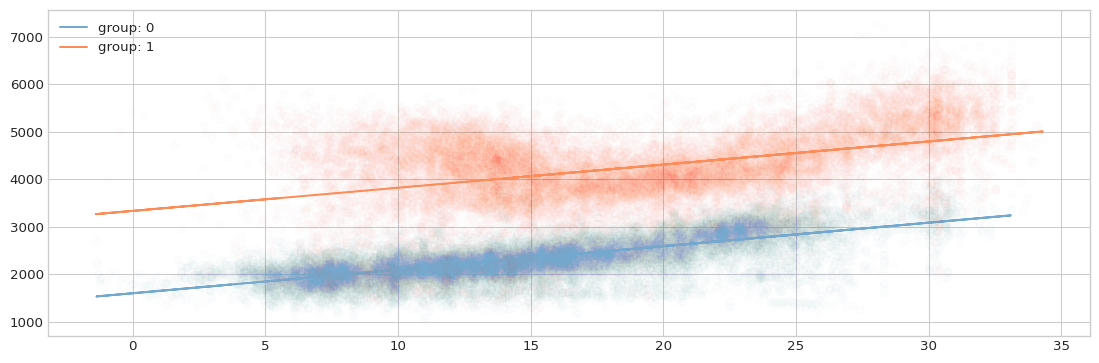

In [21]:
color_list = ['#74a9cf', '#fc8d59']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 4.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    resid = []
    for i, (group, grouped_data) in enumerate(data.groupby('groups')):
        pred = models[group].predict(grouped_data[['temperature']])
        resid.append(grouped_data['consumption'].values - pred)
        
        ax.plot(grouped_data['temperature'], pred,  
                label=f'group: {group}', c=color_list[i])
        ax.plot(grouped_data['temperature'], grouped_data['consumption'], 
                'o', c=color_list[i], alpha=0.01)
        
    ax.legend(loc='upper left')

In [22]:
print(f'Mean squared error: {np.mean(np.concatenate(resid)**2)}')

Mean squared error: 351555.7714585269


The same result can be achieved by first encoding the `hour_of_week` feature in one-hot form and then taking the tensor product between its encoding and the `temperature` feature. In this case, **an intercept must be added** directly to the `temperature` feature, so that it is possible to model a different intercept for each categorical feature's level:   

In [23]:
enc_occ = CategoricalEncoder(feature='hourofweek', 
                             max_n_categories=2,
                             stratify_by='temperature', 
                             min_samples_leaf=15,
                             encode_as='onehot'
)
feature_cat = enc_occ.fit_transform(X, y)

features = tensor_product(feature_cat, add_constant(X['temperature']))

In [24]:
model = LinearRegression(fit_intercept=False).fit(features, y)
pred = model.predict(features)

In [25]:
resid = y.values - pred
print(f'Mean squared error: {np.mean(resid**2)}')

Mean squared error: 351555.7714585269


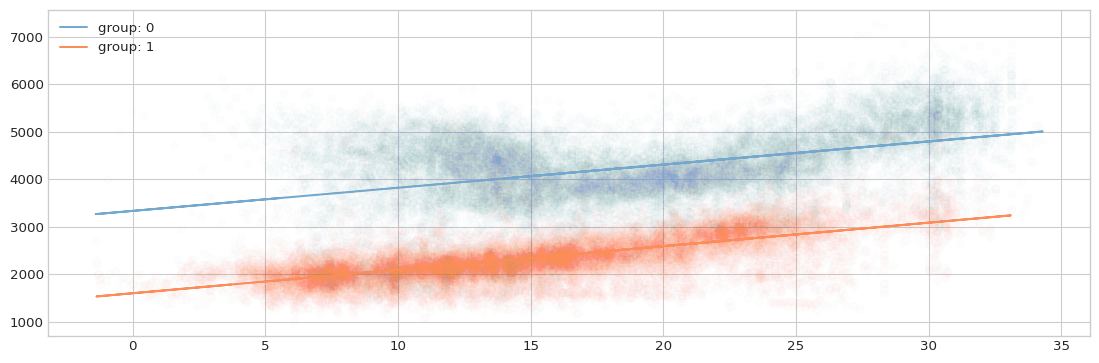

In [26]:
color_list = ['#74a9cf', '#fc8d59']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 4.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for i in range(enc_occ.n_features_out_):
        mask = feature_cat[:, i]==1
        ax.plot(data['temperature'][mask], pred[mask], label=f'group: {i}', 
                c=color_list[i])
        ax.plot(data['temperature'][mask], data['consumption'][mask], 'o', 
                c=color_list[i], alpha=0.01)
        
    ax.legend(loc='upper left')

The conclusion here is that for the case of one categorical and one linear numerical feature, we can model the interaction by first encoding the categorical feature in one-hot form and then taking the tensor product between this encoding and the numerical feature. 

This is supported by `ICatLinearEncoder`:

In [27]:
enc_occ = CategoricalEncoder(feature='hourofweek', 
                             max_n_categories=2,
                             stratify_by='temperature', 
                             min_samples_leaf=15,
                             encode_as='onehot'
)
enc_num = IdentityEncoder(feature='temperature', include_bias=True)

enc = ICatLinearEncoder(encoder_cat=enc_occ, encoder_num=enc_num)

In [28]:
features = enc.fit_transform(X, y)
model = LinearRegression(fit_intercept=False).fit(features, y)
pred = model.predict(features)

resid = y.values - pred
print(f'Mean squared error: {np.mean(resid**2)}')

Mean squared error: 351555.7714585269


Next, we want to encode the `temperature` feature with splines so that to capture potential non-linearities.

A ***first split, then encode*** strategy looks like this:

In [29]:
models = {}
encoders = {}

for group, grouped_data in data.groupby('groups'):
    enc = SplineEncoder(feature='temperature', 
                        n_knots=3, 
                        degree=1, 
                        strategy='uniform', 
                        extrapolation='constant', 
                        include_bias=True,
    ) 
    features = enc.fit_transform(grouped_data)
    model = LinearRegression(fit_intercept=False).fit(features, grouped_data['consumption'])
    models[group] = model
    encoders[group] = enc

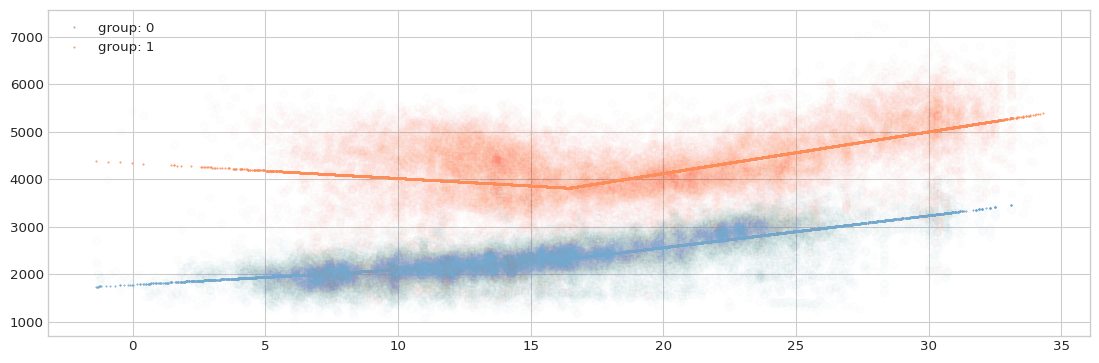

In [30]:
color_list = ['#74a9cf', '#fc8d59']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 4.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    resid = []
    for i, (group, grouped_data) in enumerate(data.groupby('groups')):
        features = encoders[group].transform(grouped_data)
        pred = models[group].predict(features)
        resid.append(grouped_data['consumption'].values - pred)
        
        ax.plot(grouped_data['temperature'], pred, '.', ms=1,
                label=f'group: {group}', c=color_list[i])
        ax.plot(grouped_data['temperature'], grouped_data['consumption'], 
                'o', c=color_list[i], alpha=0.01)
        
    ax.legend(loc='upper left')

In [31]:
print(f'Mean squared error: {np.mean(np.concatenate(resid)**2)}')

Mean squared error: 329833.67467981315


This first split, then encode strategy is implemented by `ICatSplineEncoder`. Note that:


- If the categorical encoder is already fitted, it will **not** be re-fitted during `fit` or `fit_transform`. 

- The numerical encoder will **always** be fitted (one encoder per level of categorical feature).

Since we employ cardinality reduction, the categorical encoder should be fitted using **all** data.

In [32]:
enc_occ = CategoricalEncoder(feature='hourofweek', 
                             max_n_categories=2,
                             stratify_by='temperature', 
                             min_samples_leaf=15,
                             encode_as='onehot'
           )

# Fit the categorical encoder at global level
enc_occ = enc_occ.fit(X, y)

enc_num = SplineEncoder(feature='temperature', 
                        n_knots=3, 
                        degree=1, 
                        strategy='uniform', 
                        extrapolation='constant', 
                        include_bias=True,
          ) 

In [33]:
enc = ICatSplineEncoder(encoder_cat=enc_occ, encoder_num=enc_num)
features = enc.fit_transform(X)
model = LinearRegression(fit_intercept=False).fit(features, y)
pred = model.predict(features)

In [34]:
resid = y.values - pred
print(f'Mean squared error: {np.mean(resid**2)}')

Mean squared error: 329833.6746798132


## Conditional seasonality

By combining a `CategoricalEncoder` with a `CyclicalFeatures` generator, we can create features of conditional seasonalities very similarly to how the [Prophet](https://github.com/facebook/prophet) library does it: 

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#seasonalities-that-depend-on-other-factors 

In [35]:
data = pd.DataFrame(index=pd.date_range(start='1/1/2018', end='31/12/2019', freq='D'))
data['weekday'] = data.index.dayofweek < 5

data.head()

,weekday
2018-01-01,True
2018-01-02,True
2018-01-03,True
2018-01-04,True
2018-01-05,True


In [36]:
data = CyclicalFeatures(seasonality='yearly', fourier_order=3).fit_transform(data)
data.head()

,weekday,yearly_delim_0,yearly_delim_1,yearly_delim_2,yearly_delim_3,yearly_delim_4,yearly_delim_5
2018-01-01,True,0.008601,0.999963,0.017202,0.999852,0.025801,0.999667
2018-01-02,True,0.025801,0.999667,0.051584,0.998669,0.077334,0.997005
2018-01-03,True,0.042993,0.999075,0.085906,0.996303,0.128661,0.991689
2018-01-04,True,0.060172,0.998188,0.120126,0.992759,0.179645,0.983732
2018-01-05,True,0.077334,0.997005,0.154204,0.988039,0.230151,0.973155


In [37]:
enc_cat = CategoricalEncoder(feature='weekday', encode_as='onehot')
features_cat = enc_cat.fit_transform(data)
features_cat.shape

(730, 2)

In [38]:
enc_lin = IdentityEncoder(feature='yearly', as_filter=True)
features_cyc = enc_lin.fit_transform(data)
features_cyc.shape

(730, 6)

As tensor product:

In [39]:
features_tp = tensor_product(features_cat, features_cyc)
features_tp = pd.DataFrame(data=features_tp, index=data.index)
features_tp.shape

(730, 12)

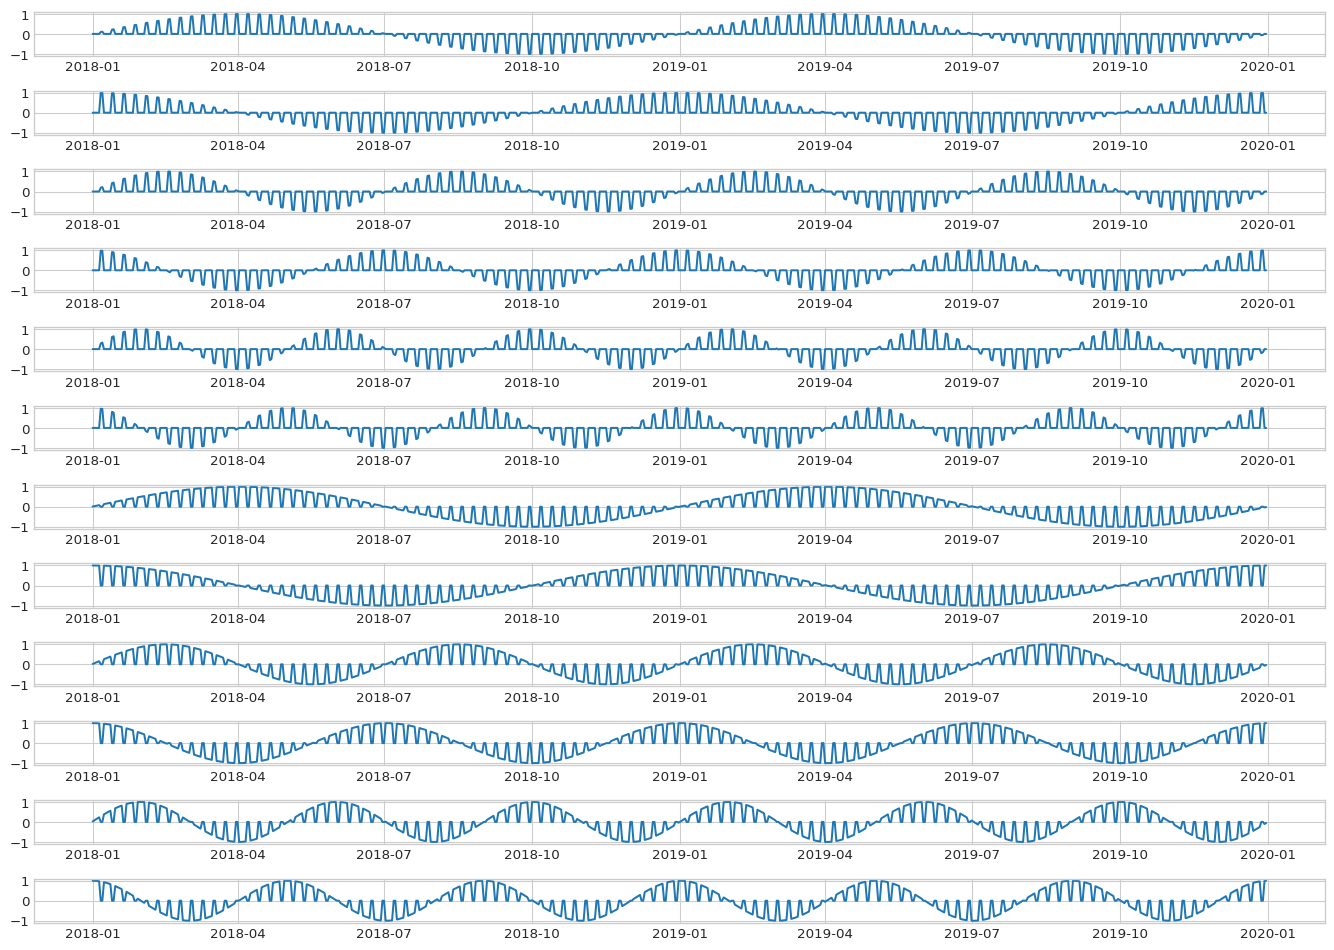

In [40]:
with plt.style.context('seaborn-whitegrid'):    
    fig, axs = plt.subplots(features_tp.shape[1], figsize=(14, 10), dpi=96)
    
    for i in range(features_tp.shape[1]):
        axs[i].plot(features_tp.loc[:, i])
    
fig.tight_layout()

In [41]:
assert np.all(features_tp.loc[data['weekday'], [0, 1, 2, 3, 4, 5]] == 0)
assert np.all(features_tp.loc[~data['weekday'], [6, 7, 8, 9, 10, 11]] == 0)

The same thing can be achieved by:

In [42]:
enc_cat = CategoricalEncoder(feature='weekday', encode_as='onehot')
enc_num = IdentityEncoder(feature='yearly', as_filter=True)

enc = ICatLinearEncoder(encoder_cat=enc_cat, encoder_num=enc_num)
features_enc = enc.fit_transform(data)
features_enc = pd.DataFrame(data=features_enc, index=data.index)

In [43]:
assert np.all(features_tp == features_enc)

Note that for the case of cyclical data, a **first split then encode** and a **first encode then split** strategies are equivalent, because the encoding uses only the information of each row and not any other value from the same column.

-------------------